## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование.

В результате эксперимента - были собраны данные.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: **конверсии покупки и среднему чеку.** 

На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: **какой из вариантов дизайна более предпочтительный.**

#### Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [2]:
data = pd.read_csv('data/ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


#### Tаблица представлена следующими полями:

* user_id — идентификатор пользователя, зашедшего на сайт;
* data — дата посещения сайта;
* group — группа теста (контрольная — А или тестовая — B);
* purchase — признак покупки: совершил ли пользователь покупку тура (1 — да, 0 — нет);
* price — цена купленного тура (если покупка не состоялась, цена равна 0).

### Проанализируем структуру данных и проведём их предобработку:

* исследуем структуру данных;
* преобразуем столбцы к необходимым типам данных.
* Убедимся в одинаковой длительности проведения A/B-тестирования в каждой из групп. Если длительность разная, унифицируем данные, удалив лишние данные для соответствующей группы.
* Проверим данные на наличие пропусков и избавимся от них, если нужно.
* Проверим, есть ли пользователи, которые в процессе A/B-теста попали в обе группы. Если да, исключим пользователей, оказавшихся в обеих группах.

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


Приведём столбец **date** - к типу данных - **datetime.** 

Убедимся в равной длительности проведения тестирования для каждой из группы. 

Для этого сгруппируем данные по признаку группы и определим первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился **A/B-тест?**.

In [4]:
data['date'] = pd.to_datetime(data['date'])
data.groupby('group')['date'].agg(['min', 'max'])

,min,max
group,,
A,2021-01-02,2021-01-24
B,2021-01-02,2021-01-24


* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? 

Ответ приведим в миллионах рублей. Например, 185.52 млн. руб.

In [5]:
print('Количество посещений сайта в группах А и B:')
display(data.groupby('group')['user_id'].agg('count'))
print('\nКоличество покупок в группах А и B:')
display(data.groupby('group')['purchase'].agg('sum'))
print('\nСумма покупок в группах А и B:')
display(data.groupby('group')['price'].agg('sum') / 1e6)

Количество посещений сайта в группах А и B:


group
A    147202
B    147276
Name: user_id, dtype: int64


Количество покупок в группах А и B:


group
A    17723
B    17514
Name: purchase, dtype: int64


Сумма покупок в группах А и B:


group
A    1436.26
B    1554.10
Name: price, dtype: float64

Проверяем, есть ли пользователи, которые в процессе **A/B-теста** попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

In [6]:
a_data = data[data['group'] == 'A']
b_data = data[data['group'] == 'B']
user_intersection = set(a_data['user_id']).intersection(set(b_data['user_id']))
print(len(user_intersection))

1895


### **Исключаем пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

Возможный вариант исключения пользователей:

In [7]:
updated_data = data[data['user_id'].apply(lambda x: x not in user_intersection)]

Где **user_intersection -** множество пересечений пользователей групп **А и B.**

### Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

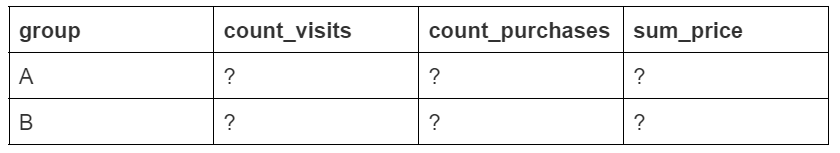
 
 
### Сгруппируем данные по признаку группы. В каждой группе рассчитаем следующие показатели:

* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуем столбцы на **count_visits, count_purchases, sum_price**.

Чему на этот раз равно количество посещений сайта в группах А и B?

In [9]:
grouped = updated_data.groupby('group').agg({
'user_id': 'count',
'purchase': 'sum',
'price': 'sum'
}).rename(columns={
'user_id': 'count_visits',
'purchase': 'count_purchases',
'price': 'sum_price'
})
display(grouped)

,count_visits,count_purchases,sum_price
group,,,
A,145307,17487,1417780000
B,145381,17290,1533010000


#### Промежуточные выводы. 

Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

Разница в количестве посещений на выбранном масштабе наблюдений крайне несущественна. Можно говорить о сбалансированности выборок.

### Добавляем в сгруппированную таблицу столбцы;
**conversion -** конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) 

**mean_check -** средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведим в процентах, например, 75.12 %
* Чему равен средний чек в группах? Ответ приведим в рублях и округляемдо целых. Например, 120519 рублей.

In [10]:
grouped['conversion'] = grouped['count_purchases']/grouped['count_visits'] * 100
grouped['mean_check'] = grouped['sum_price']/grouped['count_purchases']
print('Конверсия (в процентах) в группах А и B:')
display(grouped['conversion'].round(2))
print('\nСредний чек (в рублях) в группах А и B:')
display(grouped['mean_check'].round())

Конверсия (в процентах) в группах А и B:


group
A    12.03
B    11.89
Name: conversion, dtype: float64


Средний чек (в рублях) в группах А и B:


group
A    81076.0
B    88665.0
Name: mean_check, dtype: float64

#### Промежуточные выводы.

Конверсия в контрольной версии выше, а значит она эффективнее по данной метрике. Однако, средний чек выше в тестовой версии, что говорит о готовности клентов тратить больше, используя сайт в новом дизайне.

### Сравним варианты по покупательской способности туров. 

Для этого построим сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [12]:
pivot = updated_data[updated_data['price'] > 0].pivot_table(
    index='group', 
    columns='price', 
    values='purchase', 
    aggfunc='sum'
)

Визуализируем полученную сводную таблицу с помощью тепловой карты. 

Чему равно количество проданных туров за 60000 рублей в группах?

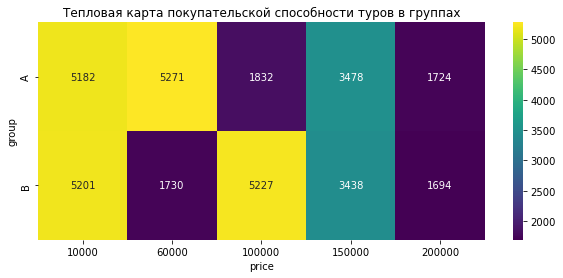

In [13]:
fig = plt.figure(figsize=(10, 4))
ax = sns.heatmap(pivot, fmt='.0f', annot=True, cmap='viridis');
ax.set_title('Тепловая карта покупательской способности туров в группах');

**Выводы.**

В **контрольной группе** - покупательская способность существенно выше в турах в **Турцию.**

В **тестовой группе** - покупательская способность существенно выше в турах в **Тайланд.**

### Прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения - A/B-тестирования.

Сгруппируем данные по дате и группе тестирования. 

В каждой группе вычислим количество посещений страницы, количество покупок и сумму покупок. 

Добавим в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)

* Чему равна конверсия 3 января 2021 года? Ответ приведём в процентах и округлим до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведёим в рублях и округлим до целого.

In [14]:
daily_data = updated_data.groupby(['date', 'group']).agg({
    'user_id':'count',
    'purchase':'sum',
    'price': 'sum'
}).reset_index().rename(columns={
    'user_id': 'count_visits',
    'purchase': 'count_purchases',
    'price': 'sum_price'
})
daily_data['conversion'] = daily_data['count_purchases']/daily_data['count_visits'] * 100
daily_data['mean_check'] = daily_data['sum_price']/daily_data['count_purchases']

print('Конверсия 3 января 2020 года:')
display(daily_data[daily_data['date'] == pd.to_datetime('2021-01-03')][['group', 'conversion']].round(2))
 
print('Средний чек 3 января 2020 года:')
display(daily_data[daily_data['date'] == pd.to_datetime('2021-01-03')][['group', 'mean_check']].round())

Конверсия 3 января 2020 года:


,group,conversion
2,A,11.34
3,B,11.39


Средний чек 3 января 2020 года:


,group,mean_check
2,A,82888.0
3,B,87480.0


### Добавляем в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

При расчете кумулятивной суммы сгруппируем данные по группам. 

Вычисляем кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведим в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведим в рублях, округлив до целых.

In [15]:
# считаем кумулятивное количество посещений страницы
daily_data['cum_count_visits'] = daily_data.groupby('group')['count_visits'].cumsum()
# считаем кумулятивное количество покупок 
daily_data['cum_count_purchases'] = daily_data.groupby('group')['count_purchases'].cumsum()
# считаем кумулятивную сумму покупок
daily_data['cum_sum_price'] = daily_data.groupby('group')['sum_price'].cumsum()
# считаем кумулятивную конверсию
daily_data['cum_conversion'] = daily_data['cum_count_purchases']/daily_data['cum_count_visits'] * 100
# считаем кумулятивный средний чек
daily_data['cum_mean_check'] = daily_data['cum_sum_price']/daily_data['cum_count_purchases']
 
print('Кумулятивная конверсия 20 января 2020 года:')
display(daily_data[daily_data['date'] == pd.to_datetime('2021-01-20')][['group', 'cum_conversion']].round(2))
print('Кумулятивный средний чек на 12 января 2020 года:')
display(daily_data[daily_data['date'] == pd.to_datetime('2021-01-12')][['group', 'cum_mean_check']].round())

Кумулятивная конверсия 20 января 2020 года:


,group,cum_conversion
36,A,11.98
37,B,11.90


Кумулятивный средний чек на 12 января 2020 года:


,group,cum_mean_check
20,A,81492.0
21,B,88352.0


### Строим кумулятивные графики конверсии и среднего чека в каждой группе по дням.

Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? 

Как соотносятся кумулятивные показатели в каждой группе?

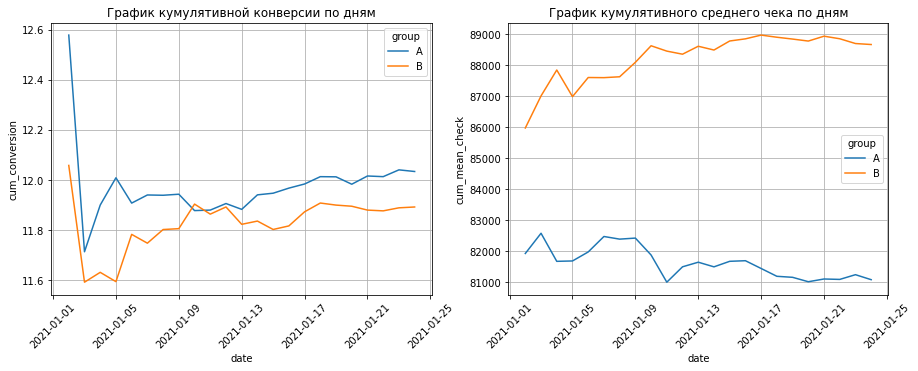

In [16]:
# создаем фигуру размером 15x5
fig, axes= plt.subplots(1, 2, figsize=(15, 5))
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='date', y='cum_conversion', data=daily_data, hue='group', ax=axes[0])
# строим lineplot для кумулятивного среднего чека во времени в каждой группе
sns.lineplot(x='date', y='cum_mean_check', data=daily_data, hue='group', ax=axes[1])
# задаем подпись к графику
axes[0].set_title('График кумулятивной конверсии по дням')
axes[1].set_title('График кумулятивного среднего чека по дням')
# задаем поворот меток на оси абсцисс
axes[0].xaxis.set_tick_params(rotation = 45)
axes[1].xaxis.set_tick_params(rotation = 45)
# задаем отображение сетки
axes[0].grid(True);
axes[1].grid(True);

На графиках видно, что линии значения метрик становятся ровнее, похожими на прямые. А значит можно утверждать о стабилизации.
При этом важно отметить следующее:

* кумулятивные показатели конверсии демонстрируют крайне малую разницу, что говорит об их равнозначности
* кумулятивный показатель среднего чека при этом выше в **тестовой группе,**  а значит по данной метрике новый дизайн сайта эффективнее.

### Переходим к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.
Проведём тестирование при  нулевой и альтернативной гипотезе:

* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислим **p-value** теста для конверсий в группах - **А и B.** 

Сравним полученное значение **p-value** с уровнем значимости **$\alpha$=0.05.** 

In [17]:
# считаем количество успехов и наблюдений в каждой из групп
converted_piv= data.groupby('group')['purchase'].agg(
    ['sum', 'count']
)
display(converted_piv)
# нулевая и альтернативная гипотезы
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А больше чем конверсия в группе B'
alpha = 0.05 # уровень значимости
#вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=converted_piv['sum'], #число "успехов"
    nobs=converted_piv['count'], #общее число наблюдений
    alternative='larger'
)
#выводим результат на экран
print('p-value: ', round(p_value, 2))
#сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

,sum,count
group,,
A,17723,147202
B,17514,147276


p-value:  0.11
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


Выводы по результатам проведенного статистического теста:

Есть ли **статистическая разница** между конверсиями в **группах - А и B?**

Статистической разницы между конверсиями нет.

### Убеждаемся в выводах, построив 95%-ый доверительный интервал для конверсий и разницы между ними. 

Используем - **$z_{крит}$** в своих расчетах

Укажим нижнюю и верхнюю границы доверительных интервалов. Границы приведим в процентах и округлив до 2 знака после запятой. 

In [20]:
def conversion_conf_interval(n, x_p, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 #погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из округленных границ интервала
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

a_data = updated_data[updated_data['group'] == 'A']
b_data = updated_data[updated_data['group'] == 'B']
conf_interval_a = conversion_conf_interval(
a_data['user_id'].count(), # размер выборки
a_data['purchase'].mean() # выборочная пропорция
)
conf_interval_b = conversion_conf_interval(
b_data['user_id'].count(), # размер выборки
b_data['purchase'].mean() # выборочная пропорция
)
print('Доверительный интервал для конверсии группы А: {}'.format(conf_interval_a))
print('Доверительный интервал для конверсии группы B: {}'.format(conf_interval_b))

def diff_conversion_conf_interval(n, xp, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = xp[1] - xp[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) #z критическое
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из округленных границ интервала
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)

# размеры выборок групп А и B
n = [a_data['user_id'].count(), b_data['user_id'].count()]
# выборочная пропорция групп A и B
xp = [a_data['purchase'].mean(), b_data['purchase'].mean()]

# строим доверительный интервал для разности
diff_inverval = diff_conversion_conf_interval(n, xp)
print('Доверительный интервал для разности конверсий: {}'.format(diff_inverval)) #выводим результат

Доверительный интервал для конверсии группы А: (11.87, 12.2)
Доверительный интервал для конверсии группы B: (11.73, 12.06)
Доверительный интервал для разности конверсий: (-0.38, 0.09)


#### Проинтерпретируем построенные доверительные интервалы для конверсий в группах А и В. 
* Есть ли перекрытие между доверительными интервалами для групп? 
* Есть ли статистическая разница между конверсиями в группах А и B?

Имеется перекрытие доверительных интервалов, а разность конверсий захватывает значение "0", что подтверждает отсутствие статистической разницы.

### Ранее  построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверяем гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Применим тест  **Шапиро-Уилка** -  для проверки гипотезы о нормальности распределения ежедневного среднего чека.
* Смотрим на нулевую и альтернативную гипотезы.
* Статистический тест с уровнем значимости $\alpha$ =0.05.

In [21]:
# нулевая и альтернативная гипотезы
H0 = 'Распределения в обеих группах нормальные'
H1 = 'Распределение в одной или обеих группах отлично от нормального'
alpha = 0.05 # уровень значимости
 
daily_data_a = daily_data[daily_data['group'] == 'A']
daily_data_b = daily_data[daily_data['group'] == 'B']
 
# вычисляем результат теста Шапиро-Уилка для выборок
shapiro_result_a = shapiro(daily_data_a['mean_check'])
shapiro_result_b = shapiro(daily_data_b['mean_check'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))
# сравниваем полученное p-value с уровнем значимости
if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value группы А 0.25
p-value группы B 0.09
Принимаем нулевую гипотезу. Распределения в обеих группах нормальные


### Cравним варианты дизайна страницы по метрике среднего чека. 

Применим **T-тест** - для проверки гипотезы о равенстве средних чеков по дням в группах.

Проведём тестирование при следующих нулевой и альтернативной гипотезе:

* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислим **p-value** - вашего теста для ежедневного среднего чека в группах А и B. 

Сравним полученное значение **p-value** - с уровнем значимости - **$\alpha$ =0.05.** 

In [22]:
# нулевая и альтернативная гипотезы
H0 = 'Ежедневные средние чеки в группах А и B равны'
H1 = 'Ежедневный средний чек в группе А меньше чем в группе B'
alpha = 0.05 #уровень значимости
 
daily_data_a = daily_data[daily_data['group'] == 'A']
daily_data_b = daily_data[daily_data['group'] == 'B']
 
#вычисляем результат T-теста для выборок
results = ttest_ind(
    daily_data_a['mean_check'],
    daily_data_b['mean_check'],
    alternative='less'
)
print('p-value:', round(results.pvalue, 2))
 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value: 0.0
Отвергаем нулевую гипотезу. Ежедневные средние чеки в группах А и B равны
Альтернативная гипотеза. H1: Ежедневный средний чек в группе А меньше чем в группе B


**Выводы по статистическому тесту.** 

Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

Статистическая разница явно имеется.

### Построим 95%-ый доверительный интервал для среднего чека в каждой группе. 

Так как выборка средних чеков небольшая, используем  **$t_{крит}$** в своих расчетах.

Укажим нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведём в процентах и округлим до целого.

In [23]:
def mean_check_conf_interval(n, x_mean, x_std, gamma=0.95):
    k = n - 1 #число степеней свободы
    alpha = 1 - gamma # уровень значимости
    t_crit = -t.ppf(alpha/2, k) # t критическое
    eps = t_crit * x_std / n**0.5 #погрешность
    lower_bound = x_mean - eps # левая (нижняя) граница
    upper_bound = x_mean + eps # правая (верхняя) граница
    # возвращаем кортеж из округленных границ интервала
    return round(lower_bound), round(upper_bound)
 
a_daily_data = daily_data[daily_data['group'] == 'A']
b_daily_data = daily_data[daily_data['group'] == 'B']
 
params_a = {
    'n': a_daily_data['count_visits'].count(), # размер выборки
    'x_mean': a_daily_data['mean_check'].mean(), # выборочное средние
    'x_std': a_daily_data['mean_check'].std() # выборочное стандартное отклонения
}
params_b = {
    'n': b_daily_data['count_visits'].count(),# размер выборки
    'x_mean': b_daily_data['mean_check'].mean(), # выборочное средние
    'x_std': b_daily_data['mean_check'].std() # выборочное стандартное отклонения
}
 
print('Доверительный интервал для среднего чека группы А: {}'.format(mean_check_conf_interval(**params_a))) 
print('Доверительный интервал для среднего чека группы B: {}'.format(mean_check_conf_interval(**params_b)))

Доверительный интервал для среднего чека группы А: (79630, 82308)
Доверительный интервал для среднего чека группы B: (87626, 89526)


Построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

Пересечение доверительных интервалов отсутствует, а значит подтверждается гипотеза о наличии статистической разницы.

### **Oбщий вывод по результатам A/B-теста**

Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему? 

**Pекомендация** - внедрение нового дизайна сайта и его посадочных страниц, так как при той же конверсии средний чек становится выше. 

Но данное решение нужно принимать только после оценки эффекта с точки зрения затрат на внедрение и конечной выгоды. 

Иными словами, дополнительный доход должен быть существенно выше понесённых на модернизацию затрат.